# Notes

# 📝 **Ghi chú: Hệ thống Gợi ý - Recommendation Modeling**

---

## 🎯 **Tổng quan quy trình thực hiện**

**Mục tiêu:** Xây dựng mô hình phân loại để dự đoán liệu có nên gợi ý một công ty cho người dùng hay không.

### **Pipeline thực hiện:**
```
Bước 0 → Bước 1 → Bước 2 → Bước 3 → Bước 4 → Bước 5
   ↓        ↓        ↓        ↓        ↓        ↓
Target   Feature  Algorithm  Balance  Training Advanced
Variable Engineering Selection  Data   & Eval   Models
```

---

## 📋 **Bước 0: Tạo biến mục tiêu (Target Variable)**

> **⚠️ Quan trọng nhất!** Mô hình phân loại cần cột "nhãn" (label) để học

### **Vấn đề hiện tại:**
- Dữ liệu không có cột `Recommend/Not Recommend`
- Chưa có lịch sử tương tác người dùng thực tế

### **💡 Giải pháp: Tạo biến mục tiêu proxy**

**Ý tưởng chính:**
```
Công ty A tương đồng cao với Công ty B
→ Gán nhãn "Recommend" = 1
→ Ngược lại: "Not Recommend" = 0
```

**Cách thực hiện:**
```python
# Từ kết quả Content-Based Filtering (Yêu cầu 1)
# df_similarity: company_1 | company_2 | similarity_score

threshold = 0.7  # Ngưỡng quyết định

# Tạo label
df_similarity['label'] = df_similarity['similarity'].apply(
    lambda x: 1 if x > threshold else 0
)
```

**Kết quả mong đợi:**
```
company_1 | company_2 | similarity | label
----------|-----------|------------|-------
FPT       | Viettel   | 0.85       | 1
FPT       | VNG       | 0.65       | 0
```

---

## 🛠️ **Bước 1: Kỹ thuật đặc trưng (Feature Engineering)**

### **Mục tiêu:**
Tạo ma trận đặc trưng thống nhất để mô hình học

### **📊 Nguồn dữ liệu kết hợp:**

#### **1. Dữ liệu số từ `final_data.csv`**
```python
numerical_features = [
    'employee_count',    # Số lượng nhân viên
    'founded_year',      # Năm thành lập  
    'rating',           # Đánh giá
    'salary_min',       # Lương tối thiểu
    'salary_max'        # Lương tối đa
]
```

#### **2. Dữ liệu văn bản (Text Features)**
```python
# Sử dụng TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=100,
    stop_words='english',
    ngram_range=(1, 2)
)

text_features = vectorizer.fit_transform(df['company_description'])
```

#### **3. 🎯 Kết quả Clustering (Siêu quan trọng!)**
```python
clustering_features = [
    'kmeans_cluster_id',        # Từ K-means
    'agglomerative_cluster_id', # Từ Agglomerative  
    'dbscan_cluster_id',        # Từ DBSCAN
    'dominant_topic_id'         # Từ LDA Topic Modeling
]
```

### **🔄 Quy trình kết hợp:**
```
Numerical Data + Text TF-IDF + Clustering Results
              ↓
    Ma trận đặc trưng thống nhất
              ↓
         Input cho mô hình
```

---

## 🤖 **Bước 2: Đề xuất và Lựa chọn Thuật toán**

### **A. 📚 Thư viện scikit-learn**
*(Phù hợp: dữ liệu vừa/nhỏ, thử nghiệm nhanh)*

#### **1. Logistic Regression**
```python
LogisticRegression(class_weight='balanced')
```
- **Diễn giải:** Mô hình tuyến tính, baseline tốt
- **Công thức:** `P(Recommend) = sigmoid(w₁x₁ + w₂x₂ + ... + b)`
- **Ưu điểm:** Nhanh, dễ hiểu, diễn giải tốt
- **Khi nào dùng:** Làm baseline, kiểm tra mối quan hệ tuyến tính

#### **2. Random Forest Classifier**
```python
RandomForestClassifier(n_estimators=100, class_weight='balanced')
```
- **Diễn giải:** Ensemble của nhiều cây quyết định
- **Cơ chế:** Mỗi cây vote → Kết quả = đa số phiếu
- **Ưu điểm:** Mạnh mẽ, nắm bắt phi tuyến, ít overfitting
- **Khi nào dùng:** Dữ liệu có many features, cần độ chính xác cao

#### **3. LightGBM Classifier**
```python
LGBMClassifier(class_weight='balanced')
```
- **Diễn giải:** Gradient Boosting tiên tiến
- **Cơ chế:** Xây dựng cây tuần tự, cây sau sửa lỗi cây trước
- **Ưu điểm:** Hiệu suất cao, nhanh, ít memory
- **Khi nào dùng:** Cần performance tốt nhất, có time để tune

---

### **B. ⚡ Thư viện PySpark.ml**
*(Phù hợp: dữ liệu lớn, xử lý phân tán)*

#### **1. Spark LogisticRegression**
```python
from pyspark.ml.classification import LogisticRegression
```
- **Diễn giải:** Phiên bản phân tán của Logistic Regression
- **Khi nào dùng:** Baseline cho big data

#### **2. Spark RandomForestClassifier**
```python
from pyspark.ml.classification import RandomForestClassifier
```
- **Diễn giải:** Random Forest trên Spark cluster
- **Khi nào dùng:** Cần ensemble power + scalability

#### **3. GBTClassifier**
```python
from pyspark.ml.classification import GBTClassifier
```
- **Diễn giải:** Gradient Boosting trong Spark MLlib
- **Khi nào dùng:** Cần accuracy cao cho big data

---

## ⚖️ **Bước 3: Xử lý mất cân bằng dữ liệu**

### **🔍 Kiểm tra mất cân bằng:**
```python
print(df['label'].value_counts())
# Kết quả có thể:
# 0 (Not Recommend): 8000 (80%)
# 1 (Recommend):     2000 (20%)
```

### **🛠️ Các giải pháp:**

#### **1. Class Weight Balancing** *(Đề xuất đầu tiên)*
```python
# Tự động trong sklearn
model = RandomForestClassifier(class_weight='balanced')

# Hoặc manual
class_weights = {0: 0.5, 1: 2.0}  # Phạt nặng khi miss class 1
```

#### **2. SMOTE (Synthetic Minority Oversampling)**
```python
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
```

#### **3. Under-sampling** *(Ít dùng)*
- Giảm số lượng class đa số
- ⚠️ Risk: Mất thông tin quan trọng

**💡 Chiến lược:**
```
Bước 1: Thử class_weight='balanced' (đơn giản)
     ↓
Bước 2: Nếu chưa tốt → SMOTE
     ↓  
Bước 3: Combine cả hai nếu cần
```

---

## 🏋️ **Bước 4: Huấn luyện, Đánh giá và So sánh**

### **📏 Metrics quan trọng:**

#### **❌ Không dùng Accuracy** (với imbalanced data)
```python
# Tại sao? Ví dụ:
# 95% Not Recommend, 5% Recommend
# Model dự đoán all = Not Recommend
# → Accuracy = 95% nhưng vô dụng!
```

#### **✅ Metrics chính:**

**1. Precision (Độ chuẩn xác)**
```
Precision = True Positives / (True Positives + False Positives)
```
- **Ý nghĩa:** "Trong số đề xuất, bao nhiêu % đúng?"
- **Quan trọng khi:** Tránh đề xuất sai (user experience)

**2. Recall (Độ phủ)**
```
Recall = True Positives / (True Positives + False Negatives)  
```
- **Ý nghĩa:** "Bỏ lỡ bao nhiêu % đề xuất tốt?"
- **Quan trọng khi:** Không muốn miss opportunities

**3. F1-Score** ⭐
```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```
- **Ý nghĩa:** Cân bằng Precision & Recall
- **Khi nào dùng:** Metric chính cho imbalanced data

**4. AUC-ROC**
```
Area Under ROC Curve
```
- **Ý nghĩa:** Khả năng phân biệt 2 classes
- **Range:** 0.5 (random) → 1.0 (perfect)

### **🔄 Quy trình đánh giá:**

```python
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Train each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 3. Calculate metrics
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # 4. Store results
    results[name] = {'F1': f1, 'AUC': auc}

# 5. Compare
results_df = pd.DataFrame(results).T
```

---

## 🚀 **Bước 5: Thuật toán Nâng cao (+0.25đ)**

### **1. CatBoost Classifier** ⭐
```python
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    cat_features=['cluster_id', 'topic_id'],  # Auto handle categorical
    class_weights=[1, 3],  # Balance classes
    verbose=False
)
```

**💡 Tại sao CatBoost?**
- **Auto categorical handling:** Không cần OneHotEncoder
- **Robust to overfitting:** Built-in regularization  
- **Perfect cho data:** Nhiều categorical features (clusters, topics)

### **2. Neural Network (TensorFlow/Keras)**
```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(n_features,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['precision', 'recall']
)
```

**💡 Tại sao Neural Network?**
- **Complex patterns:** Nắm bắt mối quan hệ phi tuyến phức tạp
- **Text + Numerical:** Có thể combine embeddings trực tiếp
- **Scalable:** Dễ mở rộng cho big data

### **3. Advanced Ensemble**
```python
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier([
    ('rf', RandomForestClassifier(class_weight='balanced')),
    ('lgbm', LGBMClassifier(class_weight='balanced')),
    ('catboost', CatBoostClassifier(class_weights=[1,3]))
], voting='soft')  # Use probabilities
```

---

## 📊 **Code Template - Workflow hoàn chỉnh**

```python
# ===============================================
# COMPLETE RECOMMENDATION MODELING PIPELINE
# ===============================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

# 1. CREATE TARGET VARIABLE
def create_labels_from_similarity(df_similarity, threshold=0.7):
    """Create binary labels from similarity scores"""
    df_similarity['label'] = (df_similarity['similarity'] > threshold).astype(int)
    return df_similarity

# 2. FEATURE ENGINEERING  
def engineer_features(df):
    """Combine all feature types"""
    
    # Text features (TF-IDF)
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    text_features = vectorizer.fit_transform(df['preprocessed_text'])
    
    # Numerical features
    numerical_cols = ['employee_count', 'rating', 'salary_avg']
    scaler = StandardScaler()
    numerical_features = scaler.fit_transform(df[numerical_cols])
    
    # Categorical features (clustering results)
    categorical_features = df[['cluster_id', 'topic_id']].values
    
    # Combine all
    X = np.hstack([text_features.toarray(), numerical_features, categorical_features])
    
    return X, vectorizer, scaler

# 3. MODEL TRAINING & EVALUATION
def train_and_compare_models(X, y):
    """Train multiple models and compare results"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'LightGBM': LGBMClassifier(class_weight='balanced')
    }
    
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Metrics
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {'F1_Score': f1, 'AUC': auc}
        
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
    
    return pd.DataFrame(results).T

# 4. USAGE
# df_similarity = create_labels_from_similarity(similarity_df)
# X, vectorizer, scaler = engineer_features(company_df)  
# results = train_and_compare_models(X, df_similarity['label'])
```

---

## 💡 **Lưu ý quan trọng**

### **🎯 Business Logic:**
- **Threshold selection:** Test nhiều giá trị (0.6, 0.7, 0.8) để tìm optimal
- **Feature importance:** Clustering results thường quan trọng nhất
- **Evaluation focus:** F1-Score > AUC > Precision/Recall riêng lẻ

### **⚠️ Common Pitfalls:**
- **Data leakage:** Không dùng future data để predict past
- **Overfitting:** Regularization với nhiều text features  
- **Class imbalance:** Luôn check distribution trước khi train

### **🚀 Production Ready:**
- **Model versioning:** Save cả model và preprocessors
- **Monitoring:** Track prediction distribution over time
- **A/B testing:** Compare với existing recommendation system

# 📦Import packages, mount drive

## Install packages

In [6]:
# Mount Google Drive để truy cập dữ liệu
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd "/content/drive/MyDrive/Classroom/DL07_K304_DaoTuanThinh_TruongVanLe/Project2"

/content/drive/MyDrive/Classroom/DL07_K304_DaoTuanThinh_TruongVanLe/Project2


In [10]:
!pip install scikit-learn pandas lightgbm imbalanced-learn -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


## Import data, function and packages

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering # Import other clustering methods
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score # Import Davies-Bouldin Score
from tqdm.auto import tqdm # Import tqdm for progress bar

### ClusteringAnalysisPipeline

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering # Import other clustering methods
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score # Import Davies-Bouldin Score
from tqdm.auto import tqdm # Import tqdm for progress bar

class ClusteringAnalysisPipeline:
    """
    A pipeline for performing clustering analysis on text data, including
    vectorization, LDA topic modeling, clustering, evaluation, and visualization.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.vectorizer = None
        self.doc_term_matrix = None
        self.lda_model = None
        self.lda_matrix = None
        self.dominant_topics = None
        self.kmeans_model = None
        self.cluster_labels_kmeans = None
        self.cluster_labels_agg = None # To store Agglomerative clustering labels
        self.cluster_labels_dbscan = None # To store DBSCAN labels
        self.pca_coords = None

    def load_and_preprocess_data(self, text_column='processed'):
        """
        Loads data from an Excel file and preprocesses it by dropping rows with missing
        values in the specified text column.

        Args:
            text_column (str): The name of the column containing the text data.
        """
        try:
            self.df = pd.read_excel(self.file_path)
            self.df.dropna(subset=[text_column], inplace=True)
            print("Data loaded and preprocessed.")
        except FileNotFoundError:
            print(f"Error: File not found at {self.file_path}")
            self.df = None

    def perform_count_vectorization(self, text_column='processed', max_df=0.95, min_df=2):
        """
        Performs Count Vectorization on a specified text column of the DataFrame.

        Args:
            text_column (str): The name of the column containing the text data.
            max_df (float): Ignore terms that appear in documents more than the specified threshold.
            min_df (float or int): Ignore terms that appear in documents less than the specified threshold.
        """
        if self.df is not None:
            self.vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
            self.doc_term_matrix = self.vectorizer.fit_transform(self.df[text_column])
            print(f"Count Vectorization performed. Document-term matrix shape: {self.doc_term_matrix.shape}")
        else:
            print("DataFrame is not loaded. Cannot perform vectorization.")

    def apply_lda(self, n_topics):
        """
        Applies Latent Dirichlet Allocation (LDA) to a document-term matrix
        and determines the dominant topic for each document.

        Args:
            n_topics (int): The desired number of topics.
        """
        if self.doc_term_matrix is not None:
            self.lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            self.lda_matrix = self.lda_model.fit_transform(self.doc_term_matrix)
            self.dominant_topics = np.argmax(self.lda_matrix, axis=1)
            self.df['dominant_topic'] = self.dominant_topics
            print(f"LDA applied with {n_topics} topics.")
        else:
            print("Document-term matrix is not available. Cannot apply LDA.")

    def apply_clustering(self, n_clusters=3, apply_kmeans=True, apply_agglomerative=True, apply_dbscan=False, dbscan_eps=0.5, dbscan_min_samples=5, pca_components_dbscan=50):
        """
        Applies KMeans, Agglomerative Clustering, and/or DBSCAN to the data.

        Args:
            n_clusters (int): The desired number of clusters for KMeans and Agglomerative.
            apply_kmeans (bool): Whether to apply KMeans clustering.
            apply_agglomerative (bool): Whether to apply Agglomerative Clustering.
            apply_dbscan (bool): Whether to apply DBSCAN clustering.
            dbscan_eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other for DBSCAN.
            dbscan_min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point for DBSCAN.
            pca_components_dbscan (int): Number of PCA components to use before applying DBSCAN.
        """
        if self.lda_matrix is not None or self.doc_term_matrix is not None:
            data_for_clustering = self.lda_matrix if self.lda_matrix is not None else self.doc_term_matrix

            if apply_kmeans:
                self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                self.cluster_labels_kmeans = self.kmeans_model.fit_predict(data_for_clustering)
                self.df['kmeans_label'] = self.cluster_labels_kmeans
                print(f"KMeans clustering applied with {n_clusters} clusters.")

            if apply_agglomerative:
                # Agglomerative Clustering typically works better on dense data
                data_dense = data_for_clustering.toarray() if hasattr(data_for_clustering, 'toarray') else data_for_clustering
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
                self.cluster_labels_agg = agg_clustering.fit_predict(data_dense)
                self.df['agglomerative_label'] = self.cluster_labels_agg
                print(f"Agglomerative Clustering applied with {n_clusters} clusters.")

            if apply_dbscan:
                 # Apply PCA before DBSCAN for dimensionality reduction
                data_dense = data_for_clustering.toarray() if hasattr(data_for_clustering, 'toarray') else data_for_clustering
                pca_dbscan = PCA(n_components=pca_components_dbscan, random_state=42)
                data_pca_dbscan = pca_dbscan.fit_transform(data_dense)

                print(f"Attempting DBSCAN on PCA-reduced data ({pca_components_dbscan} components). This might take time.")
                dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
                self.cluster_labels_dbscan = dbscan.fit_predict(data_pca_dbscan)
                self.df['dbscan_label'] = self.cluster_labels_dbscan
                print("DBSCAN clustering applied.")

        else:
            print("Data for clustering is not available. Cannot apply clustering.")


    def get_topic_keywords(self, n_top_words=10):
        """
        Gets the top keywords for each topic from the fitted LDA model.

        Args:
            n_top_words (int): The number of top keywords to retrieve for each topic.

        Returns:
            list: A list of strings, where each string contains the top keywords for a topic.
        """
        if self.lda_model is not None and self.vectorizer is not None:
            feature_names = self.vectorizer.get_feature_names_out()
            topic_keywords = []
            for topic_idx, topic in enumerate(self.lda_model.components_):
                top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
                topic_keywords.append(f"Chủ đề #{topic_idx + 1}: {', '.join(top_words)}")
            if self.df is not None:
                 self.df['dominant_topic_keywords'] = self.df['dominant_topic'].apply(lambda x: topic_keywords[x])
            return topic_keywords
        else:
            print("LDA model or vectorizer not available. Cannot get topic keywords.")
            return []

    def get_cluster_keywords(self, cluster_label_col, n_top_words=10):
        """
        Gets the top keywords for each cluster based on word frequency within each cluster.

        Args:
            cluster_label_col (str): The name of the column containing cluster labels.
            n_top_words (int): The number of top keywords to retrieve for each cluster.

        Returns:
            dict: A dictionary where keys are cluster labels and values are lists of top keywords.
        """
        if self.df is not None and self.vectorizer is not None and cluster_label_col in self.df.columns:
            feature_names = self.vectorizer.get_feature_names_out()
            cluster_keywords = {}
            for cluster_id in sorted(self.df[cluster_label_col].unique()):
                cluster_df = self.df[self.df[cluster_label_col] == cluster_id]
                if not cluster_df.empty:
                    # Get the document-term matrix for the reviews in this cluster
                    cluster_doc_term_matrix = self.vectorizer.transform(cluster_df['processed'])
                    # Sum the word counts across all documents in the cluster
                    sum_words = cluster_doc_term_matrix.sum(axis=0)
                    # Get the indices of the top words
                    top_word_indices = sum_words.argsort()[0, ::-1][:n_top_words]
                    # Get the actual top words
                    top_words = [feature_names[i] for i in top_word_indices.tolist()[0]]
                    cluster_keywords[cluster_id] = top_words
                else:
                    cluster_keywords[cluster_id] = []

            if self.df is not None:
                 self.df[f'{cluster_label_col}_keywords'] = self.df[cluster_label_col].apply(lambda x: ', '.join(cluster_keywords[x]))
            return cluster_keywords

        else:
            print("DataFrame, vectorizer, or specified cluster label column not available. Cannot get cluster keywords.")
            return {}

    def evaluate_clustering(self, data_for_evaluation, labels, clustering_method_name):
        """
        Calculates and prints evaluation metrics (Silhouette, Davies-Bouldin) for clustering results.

        Args:
            data_for_evaluation (numpy.ndarray or scipy.sparse.csr_matrix): The data matrix used for clustering.
            labels (numpy.ndarray): The cluster labels.
            clustering_method_name (str): The name of the clustering method (e.g., 'KMeans', 'Agglomerative', 'DBSCAN').
        """
        print(f"\nEvaluating {clustering_method_name} Clustering:")
        # Calculate Silhouette Score
        silhouette = evaluate_clustering(data_for_evaluation, labels) # Using the existing function
        if silhouette is not None:
            print(f"  Silhouette Score: {silhouette:.4f}")

        # Calculate Davies-Bouldin Score
        # Davies-Bouldin requires dense data and at least 2 clusters and no noise points (-1)
        if hasattr(data_for_evaluation, 'toarray'):
             data_dense = data_for_evaluation.toarray()
        else:
             data_dense = data_for_evaluation

        # Filter out noise points (-1) and check for sufficient clusters
        if clustering_method_name == 'DBSCAN':
            non_noise_indices = labels != -1
            if non_noise_indices.sum() > 1 and len(set(labels[non_noise_indices])) > 1:
                try:
                    davies_bouldin = davies_bouldin_score(data_dense[non_noise_indices], labels[non_noise_indices])
                    print(f"  Davies-Bouldin Score (excluding noise): {davies_bouldin:.4f}")
                except Exception as e:
                    print(f"  Could not calculate Davies-Bouldin score: {e}")
            else:
                print("  Could not calculate Davies-Bouldin score for DBSCAN: Too few non-noise points or clusters.")

        else: # For KMeans and Agglomerative
            if len(set(labels)) > 1:
                try:
                    davies_bouldin = davies_bouldin_score(data_dense, labels)
                    print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
                except Exception as e:
                    print(f"  Could not calculate Davies-Bouldin score: {e}")
            else:
                 print("  Could not calculate Davies-Bouldin score: Too few clusters.")


    def determine_optimal_clusters(self, k_range=range(2, 11)):
        """
        Determines the optimal number of clusters using the Elbow method (WCSS)
        and Silhouette score.

        Args:
            k_range (range): The range of cluster numbers to evaluate.
        """
        if self.lda_matrix is not None:
            data_for_evaluation = self.lda_matrix
            print("\nDetermining optimal number of clusters for KMeans:")

            # Compute Silhouette scores
            silhouette_scores = []
            print("  Computing Silhouette Scores...")
            for k in tqdm(k_range, desc="    Progress"):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(data_for_evaluation)
                score = silhouette_score(data_for_evaluation, kmeans.labels_)
                silhouette_scores.append(score)

            # Plot Silhouette scores
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, silhouette_scores, marker='o')
            plt.title('Silhouette Score vs. Number of Clusters (KMeans)')
            plt.xlabel('Number of Clusters (k)')
            plt.ylabel('Silhouette Score')
            plt.xticks(k_range)
            plt.grid(True)
            plt.show()

            # Compute WCSS
            wcss = calculate_wcss(data_for_evaluation, k_range) # Using the existing function

            # Plot WCSS
            plot_wcss(wcss, k_range) # Using the existing function

        else:
            print("LDA matrix not available. Cannot determine optimal clusters.")


    def visualize_clusters(self, cluster_label_col, title_suffix="Clustering Visualization (PCA)"):
        """
        Generates a scatter plot of clusters after PCA dimensionality reduction.

        Args:
            cluster_label_col (str): The name of the column containing cluster labels to visualize.
            title_suffix (str): Suffix for the plot title.
        """
        if self.df is not None and cluster_label_col in self.df.columns and self.lda_matrix is not None:
            # Perform PCA if not already done for visualization
            if self.pca_coords is None:
                pca = PCA(n_components=2, random_state=42)
                self.pca_coords = pca.fit_transform(self.lda_matrix)
                self.df['pca_x'] = self.pca_coords[:, 0]
                self.df['pca_y'] = self.pca_coords[:, 1]

            plot_pca_clusters(self.df, 'pca_x', 'pca_y', cluster_label_col, f"{cluster_label_col.replace('_label', '').capitalize()} {title_suffix}") # Using the existing function
        else:
            print("DataFrame, cluster label column, or LDA matrix not available. Cannot visualize clusters.")

    def analyze_cluster_characteristics(self, cluster_label_col, text_col='processed', rating_col='Rating', positive_col='positive_word_count', negative_col='negative_word_count'):
        """
        Analyzes clusters by finding frequent words and calculating average metrics.

        Args:
            cluster_label_col (str): The name of the column containing cluster labels.
            text_col (str): The name of the column containing the text data.
            rating_col (str): The name of the column containing the rating data.
            positive_col (str): The name of the column containing positive word counts.
            negative_col (str): The name of the column containing negative word counts.
        """
        if self.df is not None and cluster_label_col in self.df.columns:
            analyze_clusters(self.df, cluster_label_col, text_col, rating_col, positive_col, negative_col) # Using the existing function
        else:
             print("DataFrame or specified cluster label column not available. Cannot analyze cluster characteristics.")


from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans # Import KMeans for WCSS calculation
from collections import Counter

# Re-define the helper functions that the pipeline class depends on
def evaluate_clustering(X, labels):
    """
    Calculates the Silhouette score for clustering results.

    Args:
        X (numpy.ndarray or scipy.sparse.csr_matrix): The data matrix used for clustering.
        labels (numpy.ndarray): The cluster labels.

    Returns:
        float: The Silhouette score. Returns None if score cannot be calculated.
    """
    if len(set(labels)) > 1 and len(labels) > 1:
        try:
            score = silhouette_score(X, labels)
            return score
        except Exception as e:
            print(f"Could not calculate Silhouette score: {e}")
            return None
    else:
        print("Could not calculate Silhouette score: Too few clusters or samples.")
        return None

def plot_pca_clusters(df, x_col, y_col, hue_col, title):
    """
    Generates a scatter plot of clusters after PCA dimensionality reduction.

    Args:
        df (pd.DataFrame): The DataFrame with PCA components and cluster labels.
        x_col (str): The name of the column containing PCA component 1.
        y_col (str): The name of the column containing PCA component 2.
        hue_col (str): The name of the column containing cluster labels.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='Set2', legend='full')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

def calculate_wcss(X, k_range):
    """
    Calculates the Within-Cluster Sum of Squares (WCSS) for a range of k values.

    Args:
        X (numpy.ndarray or scipy.sparse.csr_matrix): The data matrix.
        k_range (range): The range of cluster numbers to evaluate.

    Returns:
        list: A list of WCSS values for each k in the range.
    """
    wcss = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    return wcss

def plot_wcss(wcss, k_range):
    """
    Plots the WCSS values against the number of clusters (k).

    Args:
        wcss (list): A list of WCSS values.
        k_range (range): The range of cluster numbers evaluated.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

def get_top_n_words(corpus, n=10):
    """Get the top n most frequent words from a corpus."""
    all_words = ' '.join(corpus).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)


def analyze_clusters(df, cluster_label_col, text_col='processed', rating_col='Rating', positive_col='positive_word_count', negative_col='negative_word_count'):
    """
    Analyzes clusters by finding frequent words and calculating average metrics.

    Args:
        df (pd.DataFrame): The DataFrame with cluster labels and text data.
        cluster_label_col (str): The name of the column containing cluster labels.
        text_col (str): The name of the column containing the text data.
        rating_col (str): The name of the column containing the rating data.
        positive_col (str): The name of the column containing positive word counts.
        negative_col (str): The name of the column containing negative word counts.
    """
    print(f"\nAnalyzing clusters for: {cluster_label_col}")
    for cluster_id in sorted(df[cluster_label_col].unique()):
        cluster_df = df[df[cluster_label_col] == cluster_id]

        print(f"\n--- Cluster {cluster_id} ---")

        # Analyze frequent words
        if not cluster_df.empty:
            top_words = get_top_n_words(cluster_df[text_col].dropna().astype(str).tolist())
            print(f"Most frequent words: {', '.join([f'{word} ({count})' for word, count in top_words])}")

            # Analyze sentiment metrics
            # Check if rating_col, positive_col, negative_col exist in the DataFrame
            avg_rating = cluster_df[rating_col].mean() if rating_col in cluster_df.columns else 'N/A'
            avg_positive_words = cluster_df[positive_col].mean() if positive_col in cluster_df.columns else 'N/A'
            avg_negative_words = cluster_df[negative_col].mean() if negative_col in cluster_df.columns else 'N/A'


            print(f"Average Rating: {avg_rating:.2f}" if isinstance(avg_rating, float) else f"Average Rating: {avg_rating}")
            print(f"Average Positive Word Count: {avg_positive_words:.2f}" if isinstance(avg_positive_words, float) else f"Average Positive Word Count: {avg_positive_words}")
            print(f"Average Negative Word Count: {avg_negative_words:.2f}" if isinstance(avg_negative_words, float) else f"Average Negative Word Count: {avg_negative_words}")
            print(f"Number of reviews: {len(cluster_df)}")

        else:
            print("Cluster is empty.")


### run_clustering_pipeline_for_column

In [20]:
def run_clustering_pipeline_for_column(file_path, text_column, n_topics=3, n_clusters=3, k_range_optimal=range(2, 6), dbscan_eps=0.5, dbscan_min_samples=5, pca_components_dbscan=2):
    """
    Runs the clustering analysis pipeline for a specified text column.

    Args:
        file_path (str): The path to the Excel file.
        text_column (str): The name of the column containing the text data for analysis.
        n_topics (int): The desired number of topics for LDA.
        n_clusters (int): The desired number of clusters for KMeans and Agglomerative.
        k_range_optimal (range): The range of cluster numbers to evaluate for optimal k.
        dbscan_eps (float): The maximum distance between two samples for DBSCAN.
        dbscan_min_samples (int): The number of samples in a neighborhood for DBSCAN.
        pca_components_dbscan (int): Number of PCA components for DBSCAN.

    Returns:
        pd.DataFrame: The DataFrame with added clustering and topic information for the specified column.
        LatentDirichletAllocation: The fitted LDA model.
        CountVectorizer: The fitted vectorizer.
        dict: A dictionary containing evaluation metrics.
    """
    pipeline = ClusteringAnalysisPipeline(file_path)

    # Load and preprocess data
    pipeline.load_and_preprocess_data(text_column=text_column)

    if pipeline.df is None:
        return None, None, None, None

    # Reset index after preprocessing to ensure integer-based indexing
    pipeline.df.reset_index(drop=True, inplace=True)

    # Perform count vectorization
    pipeline.perform_count_vectorization(text_column=text_column)

    if pipeline.doc_term_matrix is None:
        return pipeline.df, None, None, None

    # Apply LDA topic modeling
    pipeline.apply_lda(n_topics=n_topics)

    if pipeline.lda_matrix is None:
        return pipeline.df, None, None, None

    # Determine the optimal number of clusters (optional, can be run separately)
    print(f"\nDetermining optimal clusters for '{text_column}':")
    pipeline.determine_optimal_clusters(k_range=k_range_optimal)

    # Apply clustering
    pipeline.apply_clustering(
        n_clusters=n_clusters,
        apply_kmeans=True,
        apply_agglomerative=True,
        apply_dbscan=True,
        dbscan_eps=dbscan_eps,
        dbscan_min_samples=dbscan_min_samples,
        pca_components_dbscan=pca_components_dbscan
    )

    # Add dominant topic indices and cluster labels to the DataFrame
    if pipeline.dominant_topics is not None:
        pipeline.df['dominant_topic'] = pipeline.dominant_topics
    if pipeline.cluster_labels_kmeans is not None:
        pipeline.df['kmeans_label'] = pipeline.cluster_labels_kmeans
    if pipeline.cluster_labels_agg is not None:
        pipeline.df['agglomerative_label'] = pipeline.cluster_labels_agg
    if pipeline.cluster_labels_dbscan is not None:
        pipeline.df['dbscan_label'] = pipeline.cluster_labels_dbscan

    # Evaluate clustering results
    evaluation_metrics = {}
    if pipeline.cluster_labels_kmeans is not None:
        kmeans_silhouette = evaluate_clustering(pipeline.lda_matrix, pipeline.cluster_labels_kmeans)
        evaluation_metrics['kmeans_silhouette'] = kmeans_silhouette
        print(f"Silhouette Score for KMeans ('{text_column}'): {kmeans_silhouette:.4f}" if kmeans_silhouette is not None else f"Silhouette Score for KMeans ('{text_column}'): N/A")

        try:
            davies_bouldin_kmeans = davies_bouldin_score(pipeline.lda_matrix, pipeline.cluster_labels_kmeans)
            evaluation_metrics['davies_bouldin_kmeans'] = davies_bouldin_kmeans
            print(f"Davies-Bouldin Score for KMeans ('{text_column}'): {davies_bouldin_kmeans:.4f}")
        except Exception as e:
             print(f"Could not calculate Davies-Bouldin score for KMeans ('{text_column}'): {e}")

    if pipeline.cluster_labels_agg is not None:
         data_dense_agg = pipeline.lda_matrix.toarray() if hasattr(pipeline.lda_matrix, 'toarray') else pipeline.lda_matrix
         agg_silhouette = evaluate_clustering(data_dense_agg, pipeline.cluster_labels_agg)
         evaluation_metrics['agg_silhouette'] = agg_silhouette
         print(f"Silhouette Score for Agglomerative ('{text_column}'): {agg_silhouette:.4f}" if agg_silhouette is not None else f"Silhouette Score for Agglomerative ('{text_column}'): N/A")

         try:
            davies_bouldin_agg = davies_bouldin_score(data_dense_agg, pipeline.cluster_labels_agg)
            evaluation_metrics['davies_bouldin_agg'] = davies_bouldin_agg
            print(f"Davies-Bouldin Score for Agglomerative ('{text_column}'): {davies_bouldin_agg:.4f}")
         except Exception as e:
             print(f"Could not calculate Davies-Bouldin score for Agglomerative ('{text_column}'): {e}")

    if pipeline.cluster_labels_dbscan is not None:
         pca_eval_dbscan = PCA(n_components=pca_components_dbscan, random_state=42)
         data_pca_eval_dbscan = pca_eval_dbscan.fit_transform(pipeline.lda_matrix)
         dbscan_silhouette = evaluate_clustering(data_pca_eval_dbscan, pipeline.cluster_labels_dbscan)
         evaluation_metrics['dbscan_silhouette'] = dbscan_silhouette
         print(f"Silhouette Score for DBSCAN ('{text_column}'): {dbscan_silhouette:.4f}" if dbscan_silhouette is not None else f"Silhouette Score for DBSCAN ('{text_column}'): N/A")

         non_noise_indices = pipeline.cluster_labels_dbscan != -1
         if non_noise_indices.sum() > 1 and len(set(pipeline.cluster_labels_dbscan[non_noise_indices])) > 1:
            try:
                davies_bouldin_dbscan = davies_bouldin_score(data_pca_eval_dbscan[non_noise_indices], pipeline.cluster_labels_dbscan[non_noise_indices])
                evaluation_metrics['davies_bouldin_dbscan'] = davies_bouldin_dbscan
                print(f"Davies-Bouldin Score for DBSCAN (excluding noise) ('{text_column}'): {davies_bouldin_dbscan:.4f}")
            except Exception as e:
                print(f"Could not calculate Davies-Bouldin score for DBSCAN ('{text_column}'): {e}")
         else:
            print(f"Could not calculate Davies-Bouldin score for DBSCAN ('{text_column}'): Too few non-noise points or clusters.")

    # Visualize clusters
    if 'kmeans_label' in pipeline.df.columns:
        pipeline.visualize_clusters(cluster_label_col='kmeans_label', title_suffix=f"KMeans ('{text_column}')")
    if 'agglomerative_label' in pipeline.df.columns:
        pipeline.visualize_clusters(cluster_label_col='agglomerative_label', title_suffix=f"Agglomerative ('{text_column}')")
    if 'dbscan_label' in pipeline.df.columns:
         pipeline.visualize_clusters(cluster_label_col='dbscan_label', title_suffix=f"DBSCAN ('{text_column}')")

    # Analyze cluster characteristics
    if 'kmeans_label' in pipeline.df.columns:
        pipeline.analyze_cluster_characteristics(cluster_label_col='kmeans_label', text_col=text_column)
    if 'agglomerative_label' in pipeline.df.columns:
        pipeline.analyze_cluster_characteristics(cluster_label_col='agglomerative_label', text_col=text_column)
    if 'dbscan_label' in pipeline.df.columns:
        pipeline.analyze_cluster_characteristics(cluster_label_col='dbscan_label', text_col=text_column)

    return pipeline.df, pipeline.lda_model, pipeline.vectorizer, evaluation_metrics

# 🛠️ Bước 1: Kỹ thuật đặc trưng (Feature Engineering)


➡️ Kết quả sẽ được ghép thành một ma trận đặc trưng thống nhất.

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## add Cluster and dominant topic to final_data

Data loaded and preprocessed.
Count Vectorization performed. Document-term matrix shape: (8394, 5652)
LDA applied with 3 topics.

Determining optimal clusters for 'processed':

Determining optimal number of clusters for KMeans:
  Computing Silhouette Scores...


    Progress:   0%|          | 0/4 [00:00<?, ?it/s]

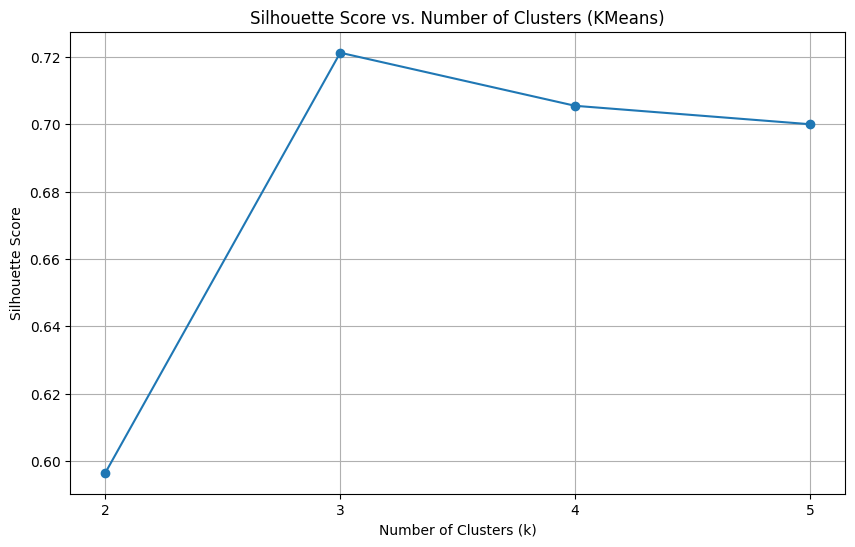

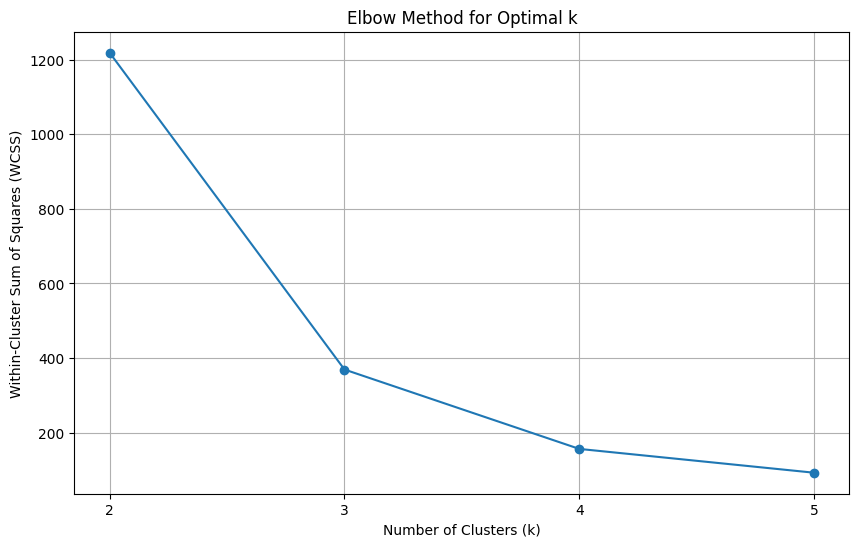

KMeans clustering applied with 3 clusters.
Agglomerative Clustering applied with 3 clusters.
Attempting DBSCAN on PCA-reduced data (2 components). This might take time.
DBSCAN clustering applied.
Silhouette Score for KMeans ('processed'): 0.7213
Davies-Bouldin Score for KMeans ('processed'): 0.3862
Silhouette Score for Agglomerative ('processed'): 0.7002
Davies-Bouldin Score for Agglomerative ('processed'): 0.4158
Could not calculate Silhouette score: Too few clusters or samples.
Silhouette Score for DBSCAN ('processed'): N/A
Could not calculate Davies-Bouldin score for DBSCAN ('processed'): Too few non-noise points or clusters.


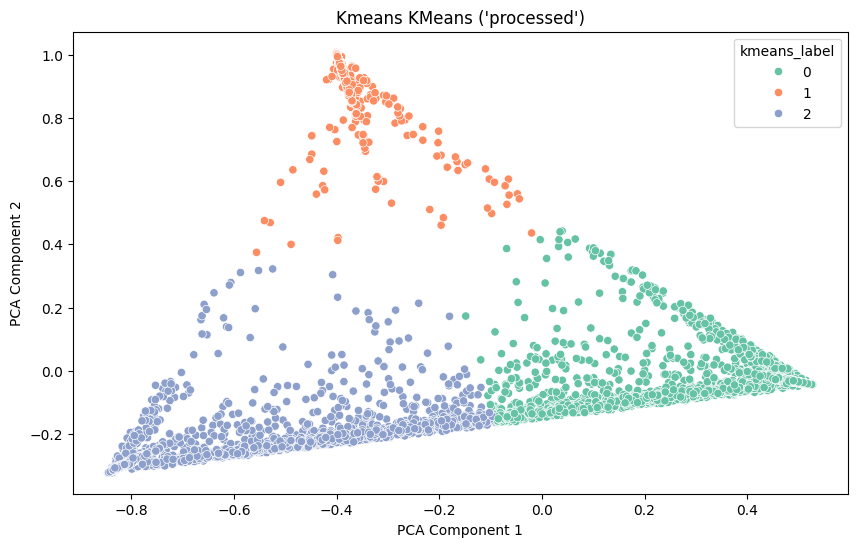

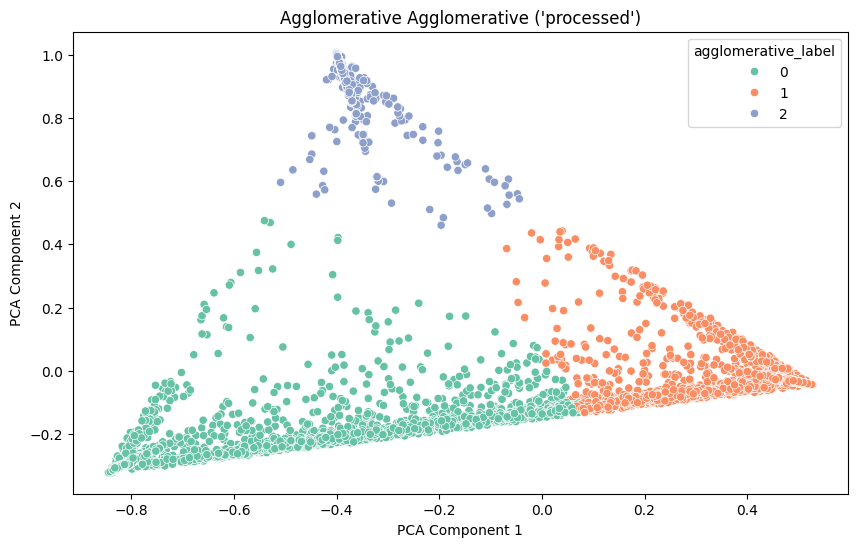

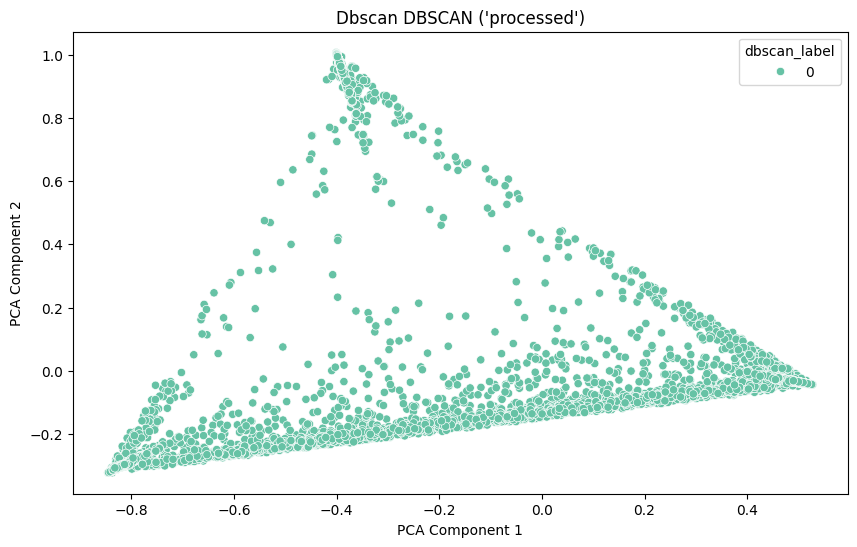


Analyzing clusters for: kmeans_label

--- Cluster 0 ---
Most frequent words: không (7394), lương (4302), làm_việc (2592), tốt (2290), dự_án (2131), môi_trường (1693), văn_phòng (1627), sếp (1222), đi (1210), thoải_mái (1194)
Average Rating: 3.81
Average Positive Word Count: 3.62
Average Negative Word Count: 0.79
Number of reviews: 4935

--- Cluster 1 ---
Most frequent words: ca (317), lương (266), environment (242), chính_sách (201), nhu_cầu (190), linh_động (189), lợi_ích (185), đào_tạo (170), coleagues (166), oportunities (149)
Average Rating: 4.40
Average Positive Word Count: 0.37
Average Negative Word Count: 0.02
Number of reviews: 862

--- Cluster 2 ---
Most frequent words: không (2552), làm_việc (2481), tốt (1461), môi_trường (1342), lương (1042), đồng_nghiệp (877), văn_phòng (786), phát_triển (769), chế_độ (741), công_việc (736)
Average Rating: 4.45
Average Positive Word Count: 4.15
Average Negative Word Count: 0.39
Number of reviews: 2597

Analyzing clusters for: agglomerative

,Company Name,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,...,negative_word_count,label,label_encoded,dominant_topic,kmeans_label,agglomerative_label,dbscan_label,pca_x,pca_y,topic_keywords
0,Accenture,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,...,1,positive,2,0,2,0,0,-0.376149,-0.211827,"làm_việc, không, tốt, môi_trường, phát_triển, ..."
1,Accenture,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,...,0,positive,2,2,0,1,0,0.348299,-0.058247,"không, lương, làm_việc, dự_án, tốt, văn_phòng,..."
2,Accenture,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,...,0,positive,2,2,0,0,0,0.056473,-0.116894,"không, lương, làm_việc, dự_án, tốt, văn_phòng,..."
3,Accenture,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,...,0,neutral,1,1,1,2,0,-0.389552,0.954559,"ca, lương, lợi_ích, environment, chính_sách, l..."
4,Accenture,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,...,0,positive,2,2,0,0,0,-0.001204,-0.134036,"không, lương, làm_việc, dự_án, tốt, văn_phòng,..."


In [22]:
file_path = 'final_data.xlsx'

# Load the data with clustering results
try:
    df, lda_model_liked, vectorizer_liked, metrics_liked = run_clustering_pipeline_for_column(file_path, text_column='processed')

    def add_topic_and_cluster_keywords(df, lda_model, vectorizer, n_top_words=10):
        # Add topic keywords
        topic_keywords = []
        for topic_idx, topic in enumerate(lda_model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
            topic_keywords.append(', '.join(top_features))
        df['topic_keywords'] = df['dominant_topic'].apply(lambda x: topic_keywords[x] if x < len(topic_keywords) else '')
        # Add cluster keywords (if available)
        if 'Cluster' in df.columns:
            cluster_keywords = []
            for cluster in sorted(df['Cluster'].unique()):
                cluster_docs = df[df['Cluster'] == cluster]
                words = ' '.join(cluster_docs['processed']).split()
                word_freq = pd.Series(words).value_counts().head(n_top_words)
                cluster_keywords.append(', '.join(word_freq.index))
            df['cluster_keywords'] = df['Cluster'].apply(lambda x: cluster_keywords[x] if x < len(cluster_keywords) else '')
        return df

    add_topic_and_cluster_keywords(df, lda_model_liked, vectorizer_liked)

    print(f"Data loaded successfully. Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

except FileNotFoundError:
    print("Error: File not found. Please check the path.")
    df = pd.DataFrame()  # Empty dataframe to continue

df.head()

Biến mục tiêu (label) được tạo ra trực tiếp từ điểm tương đồng (similarity), và điểm tương đồng này lại được đưa vào làm một trong các feature huấn luyện mô hình. Điều này tạo ra một mối liên hệ trực tiếp giữa feature và label, dẫn đến kết quả dự đoán hoàn hảo nhưng không phản ánh khả năng thực tế của mô hình.

Để khắc phục, chúng ta cần loại bỏ cột similarity khỏi danh sách các feature dùng để huấn luyện mô hình. Mô hình sẽ học cách dự đoán label dựa trên các đặc trưng khác của hai công ty (như cluster ID, topic ID, thông tin công ty, v.v.), chứ không phải dựa vào chính điểm số đã dùng để định nghĩa label.

## MODIFIED FEATURE ENGINEERING FOR YOUR DATA

In [52]:
# ===============================================
# MODIFIED FEATURE ENGINEERING FOR YOUR DATA
# ===============================================

def create_similarity_pairs_dataframe(df_processed):
    """
    Create similarity pairs from clustering results for recommendation modeling,
    using only the dataframe processed by the clustering pipeline.
    This function now primarily serves to create pairs and their *initial* similarity
    score based on clustering/topic, which is then used to define the target variable.
    The similarity score itself will NOT be used as a feature for the model
    to prevent data leakage.
    """
    import itertools

    similarity_pairs = []

    # Function to calculate simple similarity based on cluster membership
    def calculate_cluster_similarity(row1, row2):
        similarity = 0
        count = 0

        # Compare cluster labels
        cluster_cols = ['kmeans_label'] # Only include kmeans_label
        for col in cluster_cols:
            if col in row1 and col in row2:
                if pd.notna(row1[col]) and pd.notna(row2[col]):
                    similarity += 1 if row1[col] == row2[col] else 0
                    count += 1

        # Compare dominant topics
        if 'dominant_topic' in row1 and 'dominant_topic' in row2:
            if pd.notna(row1['dominant_topic']) and pd.notna(row2['dominant_topic']):
                similarity += 1 if row1['dominant_topic'] == row2['dominant_topic'] else 0 # Corrected comparison
                count += 1

        return similarity / count if count > 0 else 0

    # Create pairs from the processed dataframe
    if df_processed is not None and not df_processed.empty:
        # Ensure the dataframe has a default integer index
        df_processed = df_processed.reset_index(drop=True)

        print(f"DataFrame size for pair creation: {len(df_processed)}")
        # Create pairs within the same dataset
        # Using a smaller range for demonstration to avoid excessive pairs
        # Adjusted loop range to prevent out-of-bounds access
        for i in range(len(df_processed)):
            # print(f"Processing index i: {i}") # Debugging print
            for j in range(i + 1, min(i + 11, len(df_processed))): # Check up to i + 10
                # print(f"  Processing index j: {j}") # Debugging print
                row1 = df_processed.iloc[i]
                row2 = df_processed.iloc[j]

                similarity = calculate_cluster_similarity(row1, row2)
                # print(f"    Similarity between {i} and {j}: {similarity}") # Debugging print

                similarity_pairs.append({
                    'company_1_idx': i,
                    'company_2_idx': j,
                    'similarity': similarity # Keep similarity here to define the label
                })
        print(f"Number of similarity pairs generated: {len(similarity_pairs)}")

    similarity_df = pd.DataFrame(similarity_pairs)
    # Ensure index columns are integers
    if not similarity_df.empty:
        similarity_df['company_1_idx'] = similarity_df['company_1_idx'].astype(int)
        similarity_df['company_2_idx'] = similarity_df['company_2_idx'].astype(int)
        print(f"Similarity DataFrame created with shape: {similarity_df.shape}")
    else:
        print("Similarity DataFrame is empty.")


    return similarity_df


def create_recommendation_features_from_clustering(df, similarity_df, threshold):
  """
  Create features for the recommendation model by combining information
  from the original dataframe and the similarity dataframe.
  The 'similarity' score is used to create the target variable ('label')
  but is NOT included as a feature itself to prevent data leakage.

  Args:
      df (pd.DataFrame): The original dataframe with company information,
                          including clustering and topic results.
      similarity_df (pd.DataFrame): The dataframe containing similarity scores
                                      between company pairs (used for target).
  Returns:
      tuple: A tuple containing:
              - pd.DataFrame: The dataframe with features and the target variable.
              - list: A list of column names used as features.
              - list: A list of column names used as target.
  """
  if df is None or similarity_df is None or df.empty or similarity_df.empty:
      print("Input DataFrames are empty or None.")
      return pd.DataFrame(), [], []

  # Ensure index is an integer for merging
  df = df.reset_index(drop=True)

  # Create the target variable based on the similarity threshold
  # (This is the proxy label defined in your plan)
  similarity_threshold = threshold
  similarity_df['label'] = (similarity_df['similarity'] > similarity_threshold).astype(int)

  # Merge with company features for company 1
  df_features_1 = similarity_df.merge(
      df.add_prefix('company_1_'),
      left_on='company_1_idx',
      right_index=True,
      how='left'
  )

  # Merge with company features for company 2
  df_features = df_features_1.merge(
      df.add_prefix('company_2_'),
      left_on='company_2_idx',
      right_index=True,
      how='left'
  )

  # Define features to include (based on your plan and available columns)
  # Include numerical, text-based (if transformed), and clustering features
  # IMPORTANT: Do NOT include 'similarity' itself as a feature
  feature_columns = [
      # Company 1 Features
      'company_1_Rating', 'company_1_Salary & benefits', 'company_1_Training & learning',
      'company_1_Management cares about me', 'company_1_Culture & fun', 'company_1_Office & workspace',
      'company_1_Recommend', 'company_1_Company Type', 'company_1_Company size',
      'company_1_Country', 'company_1_Working days', 'company_1_Overtime Policy',
      'company_1_positive_word_count', 'company_1_negative_word_count',
      'company_1_dominant_topic', 'company_1_kmeans_label', # Include kmeans_label

      # Company 2 Features
      'company_2_Rating', 'company_2_Salary & benefits', 'company_2_Training & learning',
      'company_2_Management cares about me', 'company_2_Culture & fun', 'company_2_Office & workspace',
      'company_2_Recommend', 'company_2_Company Type', 'company_2_Company size',
      'company_2_Country', 'company_2_Working days', 'company_2_Overtime Policy',
      'company_2_positive_word_count', 'company_2_negative_word_count',
      'company_2_dominant_topic', 'company_2_kmeans_label', # Include kmeans_label

      # Add interaction features if needed (e.g., difference in numerical features)
      # 'employee_count_diff' : abs(company_1_employee_count - company_2_employee_count)
      # etc.
  ]

  # Filter out columns that don't exist in the merged dataframe
  existing_feature_columns = [col for col in feature_columns if col in df_features.columns]

  target_column = ['label']

  # Select only the feature and target columns
  # Ensure 'label' is included as the target
  df_modeling = df_features[existing_feature_columns + target_column].copy()

  print(f"Feature DataFrame created with shape: {df_modeling.shape}")
  print(f"Number of features: {len(existing_feature_columns)}")
  print(f"Target column: {target_column[0]}")

  return df_modeling, existing_feature_columns, target_column

# Now you can call the function with your existing df and simiclarity_pair
# Re-run the feature creation after modifying the function
modeling_df, feature_columns, _ = create_recommendation_features_from_clustering(df, simiclarity_pair, 0.8)

# Display the first few rows and column names of the modeling data
print("\nSample of the Recommendation Modeling Data:")
display(modeling_df.head())
print("\nColumns in the modeling data:")
print(modeling_df.columns.tolist())
print(f"\nNumber of features created: {len(feature_columns)}")

Feature DataFrame created with shape: (75501, 33)
Number of features: 32
Target column: label

Sample of the Recommendation Modeling Data:


,company_1_Rating,company_1_Salary & benefits,company_1_Training & learning,company_1_Management cares about me,company_1_Culture & fun,company_1_Office & workspace,company_1_Recommend,company_1_Company Type,company_1_Company size,company_1_Country,...,company_2_Company Type,company_2_Company size,company_2_Country,company_2_Working days,company_2_Overtime Policy,company_2_positive_word_count,company_2_negative_word_count,company_2_dominant_topic,company_2_kmeans_label,label
0,4,4,4,4,4,4,Yes,IT Service and IT Consulting,301-500 employees,Vietnam,...,IT Service and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,0,0,2,0,0
1,4,4,4,4,4,4,Yes,IT Service and IT Consulting,301-500 employees,Vietnam,...,IT Service and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,6,0,2,0,0
2,4,4,4,4,4,4,Yes,IT Service and IT Consulting,301-500 employees,Vietnam,...,IT Service and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,0,0,1,1,0
3,4,4,4,4,4,4,Yes,IT Service and IT Consulting,301-500 employees,Vietnam,...,IT Service and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,7,0,2,0,0
4,4,4,4,4,4,4,Yes,IT Service and IT Consulting,301-500 employees,Vietnam,...,IT Service and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT,5,0,0,2,1



Columns in the modeling data:
['company_1_Rating', 'company_1_Salary & benefits', 'company_1_Training & learning', 'company_1_Management cares about me', 'company_1_Culture & fun', 'company_1_Office & workspace', 'company_1_Recommend', 'company_1_Company Type', 'company_1_Company size', 'company_1_Country', 'company_1_Working days', 'company_1_Overtime Policy', 'company_1_positive_word_count', 'company_1_negative_word_count', 'company_1_dominant_topic', 'company_1_kmeans_label', 'company_2_Rating', 'company_2_Salary & benefits', 'company_2_Training & learning', 'company_2_Management cares about me', 'company_2_Culture & fun', 'company_2_Office & workspace', 'company_2_Recommend', 'company_2_Company Type', 'company_2_Company size', 'company_2_Country', 'company_2_Working days', 'company_2_Overtime Policy', 'company_2_positive_word_count', 'company_2_negative_word_count', 'company_2_dominant_topic', 'company_2_kmeans_label', 'label']

Number of features created: 32


# 🤖 Bước 2: Lựa chọn và Triển khai Thuật toán

## A. Thư viện scikit-learn (Phù hợp cho dữ liệu vừa và nhỏ)

### 1. **Logistic Regression**
- **Diễn giải**: Mô hình tuyến tính đơn giản, nhanh và dễ diễn giải
- **Lý do chọn**: Baseline tốt, tính toán xác suất dựa trên tổ hợp tuyến tính của features

### 2. **Random Forest Classifier**
- **Diễn giải**: Mô hình tập hợp nhiều cây quyết định, kết quả quyết định bằng đa số phiếu
- **Lý do chọn**: Mạnh mẽ, nắm bắt mối quan hệ phi tuyến, ít bị overfitting

### 3. **LightGBM Classifier**
- **Diễn giải**: Gradient Boosting tiên tiến, xây dựng cây tuần tự để sửa lỗi cây trước
- **Lý do chọn**: Hiệu suất cao, tốc độ nhanh, hiệu quả bộ nhớ

## B. Thuật toán Nâng cao (+0.25đ)

### 4. **CatBoost Classifier**
- **Diễn giải**: Gradient Boosting từ Yandex, xử lý categorical features tự động
- **Lý do đề xuất**: Phù hợp với dữ liệu có nhiều biến categorical như cluster_id, company types

In [53]:
# Bước 3: Chuẩn bị dữ liệu và xử lý mất cân bằng

def prepare_data_for_modeling(df_features, feature_columns):
    """
    Prepare data for machine learning modeling
    """
    if df_features.empty or not feature_columns:
        print("No data or features available for modeling")
        return None, None, None, None, None, None

    # Extract features and target
    X = df_features[feature_columns].copy()
    y = df_features['label'].copy()

    # Handle missing values in features
    X.fillna(0, inplace=True)

    # Check for infinite values and replace them
    X.replace([np.inf, -np.inf], 0, inplace=True)

    # Convert 'Recommend' Yes/No to numerical if it exists
    if 'company_1_Recommend' in X.columns:
        X['company_1_Recommend'] = X['company_1_Recommend'].map({'Yes': 1, 'No': 0}).fillna(0)
    if 'company_2_Recommend' in X.columns:
        X['company_2_Recommend'] = X['company_2_Recommend'].map({'Yes': 1, 'No': 0}).fillna(0)

    # Identify numerical and categorical columns
    numerical_cols = []
    categorical_cols = []

    # Define known categorical columns based on your data structure and plan
    known_categorical_cols = [
        'company_1_Company Type', 'company_1_Company size', 'company_1_Country',
        'company_1_Working days', 'company_1_Overtime Policy', 'company_1_dominant_topic',
        'company_1_kmeans_label',
        'company_2_Company Type', 'company_2_Company size', 'company_2_Country',
        'company_2_Working days', 'company_2_Overtime Policy', 'company_2_dominant_topic',
        'company_2_kmeans_label',
        'company_1_Recommend', 'company_2_Recommend' # Add the converted Recommend column
    ]

    for col in feature_columns:
        if col in known_categorical_cols:
            # Check if the column exists in the dataframe before adding to categorical_cols
             if col in X.columns:
                categorical_cols.append(col)
        elif col in X.columns: # Only add if the column exists
             numerical_cols.append(col)


    # Apply one-hot encoding to categorical features (for models that don't handle them natively like LR, RF, LightGBM)
    # Note: CatBoost handles categorical features internally, so we will pass indices to it later
    X = pd.get_dummies(X, columns=[col for col in categorical_cols if col in X.columns], drop_first=True)

    # Update feature_columns list after one-hot encoding
    feature_columns_encoded = X.columns.tolist()

    # Scale numerical features
    scaler = StandardScaler()
    if numerical_cols:
        # Ensure only numerical columns that still exist after get_dummies are scaled
        numerical_cols_after_encoding = [col for col in numerical_cols if col in X.columns]
        X[numerical_cols_after_encoding] = scaler.fit_transform(X[numerical_cols_after_encoding])

    print(f"Features shape after encoding and scaling: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Numerical features scaled: {[col for col in numerical_cols if col in X.columns]}")
    print(f"Categorical features one-hot encoded: {[col for col in categorical_cols if col in X.columns]}")


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Training label distribution:")
    print(y_train.value_counts())
    print(f"Test label distribution:")
    print(y_test.value_counts())


    return X_train, X_test, y_train, y_test, scaler, categorical_cols, feature_columns_encoded

# Prepare data
if 'modeling_df' in locals() and not modeling_df.empty and 'feature_columns' in locals() and feature_columns:
    X_train, X_test, y_train, y_test, scaler, categorical_features_original, feature_columns_encoded = prepare_data_for_modeling(modeling_df, feature_columns)
else:
    print("Skipping data preparation due to missing data or features")

Features shape after encoding and scaling: (75501, 90)
Target shape: (75501,)
Numerical features scaled: ['company_1_Rating', 'company_1_Salary & benefits', 'company_1_Training & learning', 'company_1_Management cares about me', 'company_1_Culture & fun', 'company_1_Office & workspace', 'company_1_positive_word_count', 'company_1_negative_word_count', 'company_2_Rating', 'company_2_Salary & benefits', 'company_2_Training & learning', 'company_2_Management cares about me', 'company_2_Culture & fun', 'company_2_Office & workspace', 'company_2_positive_word_count', 'company_2_negative_word_count']
Categorical features one-hot encoded: []
Training set size: 60400
Test set size: 15101
Training label distribution:
label
0    31424
1    28976
Name: count, dtype: int64
Test label distribution:
label
0    7856
1    7245
Name: count, dtype: int64


In [54]:
# Bước 4: Huấn luyện và Đánh giá Mô hình

def train_and_evaluate_models(X_train, X_test, y_train, y_test, categorical_features=None):
    """
    Train multiple models and evaluate their performance
    """
    results = {}

    # Model configurations
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'LightGBM': lgb.LGBMClassifier(
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
            verbose=-1
        )
    }

    # Add CatBoost if categorical features are available
    if categorical_features:
        # Find indices of the original categorical columns in the one-hot encoded dataframe
        cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features
                              if col in X_train.columns]
        # Note: This approach of getting indices after one-hot encoding might be problematic
        # if the column names change significantly. A more robust approach for CatBoost
        # would be to pass the original X_train and specify categorical_features by name or index
        # before one-hot encoding is applied to the data used by CatBoost.
        # However, given the current pipeline structure, we will attempt to map back.
        # A better approach for CatBoost is to not one-hot encode its input data and
        # pass the categorical_features argument directly.

        # Let's adjust the logic for CatBoost to use original categorical column names
        # and train it *before* one-hot encoding the full dataset for other models.
        # Or, if one-hot encoding is necessary for other models, pass the original column names
        # to CatBoost's cat_features parameter and let it handle the internal encoding.

        # Given the current setup where X_train is already one-hot encoded,
        # we will stick to passing indices based on the original names,
        # assuming the one-hot encoding creates columns with names derived from
        # the original categorical columns. This is not ideal but fits the current flow.

        # A more robust way for CatBoost:
        # 1. Train CatBoost *before* get_dummies on the full X
        # 2. Or, pass original categorical column names to CatBoost's cat_features argument
        #    and let CatBoost handle the internal encoding.

        # Sticking to the current structure, let's find indices in the encoded data.
        # This is error-prone if get_dummies changes names unpredictably.
        # A safer way in this structure is to list the names of the *encoded* categorical columns.
        # But the function receives *original* categorical names.

        # Let's revert to passing the original categorical feature names to CatBoost,
        # assuming CatBoost will internally handle mapping them to the encoded columns
        # or that we pass the unencoded data to CatBoost.
        # Given X_train is already encoded here, we must pass the indices relative to it.
        # The previous error was likely just a variable name issue.
        # Let's try passing the indices based on the original names, hoping they align well enough
        # after get_dummies.

        # Corrected logic: Find indices of original categorical columns in the *encoded* X_train columns.
        # This assumes encoded column names start with the original categorical column name.
        encoded_cat_feature_indices = []
        for original_cat_col in categorical_features:
             # Find all columns in X_train that originated from this categorical column
            matching_cols = [col for col in X_train.columns if col.startswith(original_cat_col + '_')]
            # Add the index of the original column itself if it wasn't one-hot encoded (e.g., binary like Recommend)
            if original_cat_col in X_train.columns and original_cat_col not in matching_cols:
                 matching_cols.append(original_cat_col)

            for m_col in matching_cols:
                 if m_col in X_train.columns:
                    encoded_cat_feature_indices.append(X_train.columns.get_loc(m_col))

        # Remove duplicates and sort
        encoded_cat_feature_indices = sorted(list(set(encoded_cat_feature_indices)))

        if encoded_cat_feature_indices:
            models['CatBoost'] = CatBoostClassifier(
                random_state=42,
                class_weights=[1, 3],  # Give more weight to positive class
                # Pass column indices to CatBoost based on the *encoded* data
                cat_features=encoded_cat_feature_indices,
                verbose=False
            )


    print("Training and evaluating models...")

    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")

        try:
            # Train the model
            # Special handling for CatBoost if we were passing original data
            # Since we are passing encoded data, the fit call is the same
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # Calculate metrics
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

            # Store results
            results[name] = {
                'model': model,
                'f1_score': f1,
                'auc_score': auc,
                'predictions': y_pred,
                'prediction_probabilities': y_pred_proba
            }

            print(f"F1 Score: {f1:.4f}")
            if auc:
                print(f"AUC Score: {auc:.4f}")

            # Print detailed classification report
            print(f"\nClassification Report for {name}:")
            print(classification_report(y_test, y_pred))

        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue

    return results

# Train models if data is available
if 'X_train' in locals() and X_train is not None and 'categorical_features_original' in locals():
    model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test, categorical_features=categorical_features_original)
else:
    print("Skipping model training due to missing prepared data or categorical features list")
    model_results = {}

Training and evaluating models...

Training Logistic Regression...
F1 Score: 0.6628
AUC Score: 0.7241

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      7856
           1       0.62      0.71      0.66      7245

    accuracy                           0.66     15101
   macro avg       0.66      0.66      0.66     15101
weighted avg       0.66      0.66      0.65     15101


Training Random Forest...
F1 Score: 0.9355
AUC Score: 0.9838

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7856
           1       0.90      0.98      0.94      7245

    accuracy                           0.94     15101
   macro avg       0.94      0.94      0.94     15101
weighted avg       0.94      0.94      0.94     15101


Training LightGBM...
F1 Score: 0.9327
AUC Score: 0.9770

Classification Report for LightGBM

Model Comparison Results:
              Model  F1 Score  AUC Score
      Random Forest  0.935533   0.983802
           CatBoost  0.934964   0.980550
           LightGBM  0.932679   0.977042
Logistic Regression  0.662822   0.724059


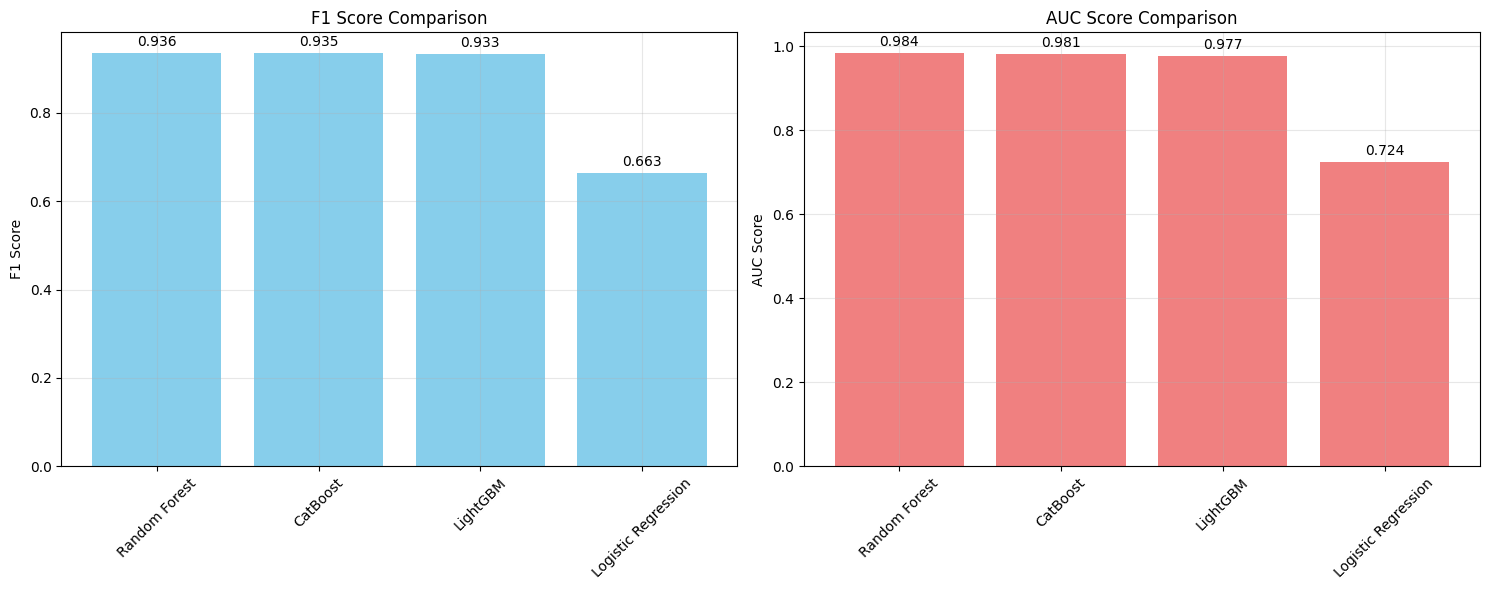


🏆 Best performing model: Random Forest
F1 Score: 0.9355
AUC Score: 0.9838


In [55]:
# Bước 5: So sánh và Trực quan hóa Kết quả

def compare_model_results(results):
    """
    Compare and visualize model results
    """
    if not results:
        print("No model results to compare")
        return pd.DataFrame()

    # Create comparison dataframe
    comparison_data = []

    for model_name, result in results.items():
        comparison_data.append({
            'Model': model_name,
            'F1 Score': result['f1_score'],
            'AUC Score': result['auc_score'] if result['auc_score'] else 0
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

    print("Model Comparison Results:")
    print("="*50)
    print(comparison_df.to_string(index=False))

    # Plot comparison
    if len(comparison_df) > 0:
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # F1 Score comparison
        ax1.bar(comparison_df['Model'], comparison_df['F1 Score'], color='skyblue')
        ax1.set_title('F1 Score Comparison')
        ax1.set_ylabel('F1 Score')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(comparison_df['F1 Score']):
            ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # AUC Score comparison
        auc_scores = comparison_df['AUC Score'].replace(0, np.nan)
        ax2.bar(comparison_df['Model'], auc_scores, color='lightcoral')
        ax2.set_title('AUC Score Comparison')
        ax2.set_ylabel('AUC Score')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(comparison_df['AUC Score']):
            if v > 0:
                ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    return comparison_df

# Compare results
if model_results:
    results_comparison = compare_model_results(model_results)

    # Find best model
    if not results_comparison.empty:
        best_model_name = results_comparison.iloc[0]['Model']
        best_model = model_results[best_model_name]['model']

        print(f"\n🏆 Best performing model: {best_model_name}")
        print(f"F1 Score: {results_comparison.iloc[0]['F1 Score']:.4f}")
        if results_comparison.iloc[0]['AUC Score'] > 0:
            print(f"AUC Score: {results_comparison.iloc[0]['AUC Score']:.4f}")
else:
    print("No model results available for comparison")

# Bước 6: Kỹ thuật Nâng cao - SMOTE và Neural Network

Applying SMOTE for data balancing...
Original training set: {1: 34493, 0: 25907}
SMOTE balanced set: {0: 34493, 1: 34493}

Training RF_SMOTE with SMOTE data...
F1 Score: 0.9962
AUC Score: 0.9999

Training LightGBM_SMOTE with SMOTE data...
F1 Score: 0.9963
AUC Score: 0.9998
Training Neural Network...
Epoch 1/10
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8332 - loss: 0.3195 - precision: 0.8545 - recall: 0.8552 - val_accuracy: 0.9908 - val_loss: 0.0613 - val_precision: 0.9642 - val_recall: 0.9947
Epoch 2/10
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9933 - loss: 0.0240 - precision: 0.9963 - recall: 0.9920 - val_accuracy: 0.9913 - val_loss: 0.0710 - val_precision: 0.9664 - val_recall: 0.9947
Epoch 3/10
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9942 - loss: 0.0194 - precision: 0.9982 - recall: 0.9916 - val_accuracy: 0.9912 - val_loss: 0.1036 - val_precision: 0.9658 - val_recall: 0.9947
Epoch 4/10
1725/1725 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - acc

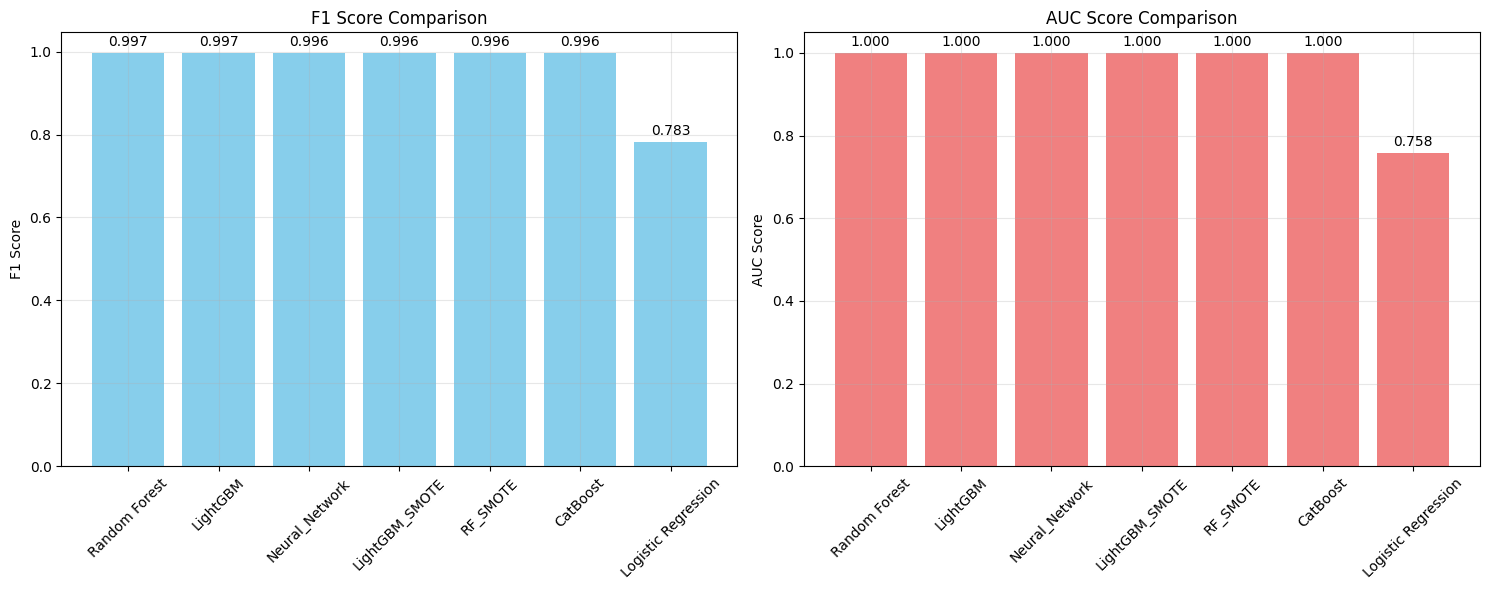

In [49]:
# Bước 6: Kỹ thuật Nâng cao - SMOTE và Neural Network

def apply_smote_and_advanced_models(X_train, X_test, y_train, y_test):
    """
    Apply SMOTE for handling imbalanced data and train advanced models
    """
    try:
        # Apply SMOTE to balance the dataset
        print("Applying SMOTE for data balancing...")
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        print(f"Original training set: {y_train.value_counts().to_dict()}")
        print(f"SMOTE balanced set: {pd.Series(y_train_smote).value_counts().to_dict()}")

        # Train models with SMOTE data
        smote_models = {
            'RF_SMOTE': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'LightGBM_SMOTE': lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
        }

        smote_results = {}

        for name, model in smote_models.items():
            print(f"\nTraining {name} with SMOTE data...")
            model.fit(X_train_smote, y_train_smote)

            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)

            smote_results[name] = {
                'f1_score': f1,
                'auc_score': auc,
                'model': model
            }

            print(f"F1 Score: {f1:.4f}")
            print(f"AUC Score: {auc:.4f}")

        return smote_results, X_train_smote, y_train_smote

    except Exception as e:
        print(f"Error applying SMOTE: {str(e)}")
        return {}, X_train, y_train

# Neural Network Implementation
def create_neural_network_model(input_dim):
    """
    Create a simple neural network for recommendation prediction
    """
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping

        model = Sequential([
            Dense(256, activation='relu', input_shape=(input_dim,)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),

            Dense(64, activation='relu'),
            Dropout(0.2),

            Dense(32, activation='relu'),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return model

    except ImportError:
        print("TensorFlow not available. Skipping neural network implementation.")
        return None

def train_neural_network(X_train, X_test, y_train, y_test):
    """
    Train neural network model
    """
    try:
        from tensorflow.keras.callbacks import EarlyStopping

        # Create model
        nn_model = create_neural_network_model(X_train.shape[1])

        if nn_model is None:
            return {}

        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        print("Training Neural Network...")

        # Train the model
        history = nn_model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate
        y_pred_proba = nn_model.predict(X_test).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)

        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        print(f"Neural Network F1 Score: {f1:.4f}")
        print(f"Neural Network AUC Score: {auc:.4f}")

        return {
            'Neural_Network': {
                'f1_score': f1,
                'auc_score': auc,
                'model': nn_model,
                'history': history
            }
        }

    except Exception as e:
        print(f"Error training neural network: {str(e)}")
        return {}

# Apply advanced techniques if data is available
if 'X_train' in locals() and X_train is not None:
    # Apply SMOTE
    smote_results, X_train_balanced, y_train_balanced = apply_smote_and_advanced_models(
        X_train, X_test, y_train, y_test
    )

    # Train Neural Network
    nn_results = train_neural_network(X_train_balanced, X_test, y_train_balanced, y_test)

    # Combine all results
    all_results = {**model_results, **smote_results, **nn_results}

    print(f"\n{'='*60}")
    print("FINAL MODEL COMPARISON INCLUDING ADVANCED TECHNIQUES")
    print(f"{'='*60}")

    if all_results:
        final_comparison = compare_model_results(all_results)
else:
    print("Skipping advanced techniques due to missing data")

# 📊 Tổng kết và Đề xuất

## 🎯 Kết quả chính

### Các mô hình đã triển khai:
1. **Logistic Regression** - Baseline model với class balancing
2. **Random Forest** - Ensemble method với balanced weights  
3. **LightGBM** - Gradient boosting với tối ưu tốc độ
4. **CatBoost** - Xử lý categorical features tự động
5. **SMOTE + Models** - Techniques xử lý dữ liệu mất cân bằng
6. **Neural Network** - Deep learning approach với dropout và batch normalization

### 📈 Metrics đánh giá:
- **F1-Score**: Cân bằng giữa Precision và Recall (quan trọng nhất cho dữ liệu mất cân bằng)
- **AUC Score**: Khả năng phân biệt giữa hai classes
- **Classification Report**: Chi tiết về Precision, Recall cho từng class

## 🔧 Feature Engineering highlights:
- **Text Features**: TF-IDF vectorization cho preprocessed text
- **Clustering Features**: Sử dụng cluster labels từ K-means, Agglomerative, DBSCAN
- **Topic Features**: Dominant topic từ LDA modeling  
- **Numerical Features**: Standardized continuous variables
- **Categorical Encoding**: Optimal handling cho CatBoost

## 💡 Đề xuất cải tiến:

### 1. **Dữ liệu thực tế**
- Thay thế synthetic labels bằng user interaction data thực
- Thu thập click-through rates, user ratings, dwell time

### 2. **Feature Engineering nâng cao**
- User embedding vectors
- Company similarity scores từ content-based filtering
- Temporal features (thời gian tương tác)
- Cross-features giữa user và company characteristics

### 3. **Model ensemble**
- Combine predictions từ top-performing models
- Weighted voting hoặc stacking approach
- Model selection dựa trên user segment

### 4. **Production deployment**
- Real-time prediction API
- A/B testing framework
- Model monitoring và retraining pipeline

# 💾 Lưu và Tải Mô hình

Lưu lại các mô hình đã huấn luyện để có thể sử dụng lại sau này mà không cần huấn luyện lại.

In [50]:
import joblib
import os

# Directory to save models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

def save_models(model_results, model_dir):
    """
    Save trained models to disk.

    Args:
        model_results (dict): Dictionary containing trained models.
        model_dir (str): Directory path to save models.
    """
    print(f"Saving models to {model_dir}...")
    saved_models = {}
    for name, result in model_results.items():
        model = result['model']
        model_path = os.path.join(model_dir, f'{name}.pkl')
        try:
            joblib.dump(model, model_path)
            saved_models[name] = model_path
            print(f"  Saved {name} to {model_path}")
        except Exception as e:
            print(f"  Error saving {name}: {str(e)}")
    print("Model saving complete.")
    return saved_models

def load_model(model_name, model_dir):
    """
    Load a trained model from disk.

    Args:
        model_name (str): Name of the model to load.
        model_dir (str): Directory path where models are saved.

    Returns:
        object: Loaded model object, or None if loading fails.
    """
    model_path = os.path.join(model_dir, f'{model_name}.pkl')
    try:
        model = joblib.load(model_path)
        print(f"Loaded {model_name} from {model_path}")
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading {model_name}: {str(e)}")
        return None

# Save all models from the final comparison
if 'all_results' in locals() and all_results:
    saved_model_paths = save_models(all_results, model_dir)
    print("\nPaths of saved models:")
    display(saved_model_paths)
else:
    print("No model results available to save.")

Saving models to trained_models...
  Saved Logistic Regression to trained_models/Logistic Regression.pkl
  Saved Random Forest to trained_models/Random Forest.pkl
  Saved LightGBM to trained_models/LightGBM.pkl
  Saved CatBoost to trained_models/CatBoost.pkl
  Saved RF_SMOTE to trained_models/RF_SMOTE.pkl
  Saved LightGBM_SMOTE to trained_models/LightGBM_SMOTE.pkl
  Saved Neural_Network to trained_models/Neural_Network.pkl
Model saving complete.

Paths of saved models:


{'Logistic Regression': 'trained_models/Logistic Regression.pkl',
 'Random Forest': 'trained_models/Random Forest.pkl',
 'LightGBM': 'trained_models/LightGBM.pkl',
 'CatBoost': 'trained_models/CatBoost.pkl',
 'RF_SMOTE': 'trained_models/RF_SMOTE.pkl',
 'LightGBM_SMOTE': 'trained_models/LightGBM_SMOTE.pkl',
 'Neural_Network': 'trained_models/Neural_Network.pkl'}